In [1]:
import pandas as pd 
import pathlib 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import PIL 
import glob 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization 
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
from tensorflow.keras.regularizers import l2 
import os


%matplotlib inline

from glob import glob 
import seaborn as sns
from PIL import Image 
np.random.seed(7) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV 
from sklearn.metrics import accuracy_score 
import itertools 

import keras 
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential, Model 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
from keras import backend as K 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.optimizers import Adam, RMSprop 
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.applications.inception_v3 import InceptionV3 
from keras import backend as K
import random 
import urllib.request
import matplotlib.image as mpimg 

from skimage.filters import rank, threshold_otsu 
from skimage import io 
from skimage.color import rgb2gray 
import warnings 
warnings.filterwarnings("ignore") 
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array 
from keras.utils import np_utils 
from sklearn.datasets import load_files 
from tqdm import tqdm 
from collections import Counter 
from skimage.morphology import closing, square, disk 

pd.set_option("display.max_colwidth", -1) 
from termcolor import colored 

In [2]:
eye_training = os.listdir(r'C:\Users\Admin\Downloads\archive (2)\dataset') 
print("Types of eye diseases found: ", len(eye_training)) 
print (eye_training)

Types of eye diseases found:  4
['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [3]:
eye_diseases = []  

for item in eye_training: 
 all_diseases = os.listdir(r'C:\Users\Admin\Downloads\archive (2)\dataset' + '/' +item+'/') 

 for room in all_diseases:
    eye_diseases.append((item, str('dataset_path' + '/' +item) + '/' + room)) 

In [4]:
df = pd.DataFrame(data=eye_diseases, columns=['Diseases', 'Image']) 
df.head(7) 

,Diseases,Image
0,cataract,dataset_path/cataract/0_left.jpg
1,cataract,dataset_path/cataract/103_left.jpg
2,cataract,dataset_path/cataract/1062_right.jpg
3,cataract,dataset_path/cataract/1083_left.jpg
4,cataract,dataset_path/cataract/1084_right.jpg
5,cataract,dataset_path/cataract/1102_left.jpg
6,cataract,dataset_path/cataract/1102_right.jpg


In [5]:
batch_size = 32

eye_img_height = 360
eye_img_width = 360

In [6]:
eye_directory = pathlib.Path(r'C:\Users\Admin\Downloads\archive (2)\dataset') 

In [7]:
# creates a dataset for the training process by loading images from the directory and applying preprocessing on them

eye_train_ds = image_dataset_from_directory(eye_directory, 
                                        seed = 111, 
                                        image_size=(eye_img_height, eye_img_width), 
                                        validation_split=0.2,
                                        subset='training') 

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [8]:
# same as above, except for validation
eye_validation_ds = image_dataset_from_directory(eye_directory, 
                                      seed = 111, 
                                      image_size=(eye_img_height, eye_img_width), 
                                      validation_split=0.2, 
                                      subset='validation',)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


# Modeling

In [9]:
batch_size = 64

input_shape = (360, 360, 3)

classes = 4 # number of eye disease type

In [10]:
from tensorflow.keras.applications import DenseNet121 # a deep neural network architecture that connects each layer to every other layer in a feed-forward fashion.

dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(360,360,3)) # creates an instance of the DenseNet121 model, with pre-trained weights from the "imagenet" dataset, with the top fully-connected layer of the network removed and input shape set to (360,360,3).

In [11]:
for layer in dense.layers[:121]: # starts a for loop that will iterate over the first 121 layers of the DenseNet121 model.
    layer.trainable = False # the weights of these layers will not be updated during training.

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
# Above are just imports

model = Sequential() # creates an instance of a Sequential model, which is a linear stack of layers.
model.add(dense) # adds the DenseNet121 model to the Sequential model.
model.add(MaxPooling2D()) # adds a 2D max-pooling layer to the Sequential model.
model.add(BatchNormalization()) # adds a batch normalization layer to the model.
model.add(Dropout(0.5)) # adds a dropout layer to the model with a dropout rate of 0.5.

model.add(Flatten()) # adds a Flatten layer to the model.
model.add(Dense(512,activation= "relu")) # adds a dense layer with 512 neurons and a rectified linear unit (ReLU) activation function.
model.add(Dropout(0.5)) # adds another dropout layer to the model with a dropout rate of 0.5.
model.add(Dense(4, activation = "sigmoid")) # adds the final dense layer with 4 neurons and a sigmoid activation function. (Used for 4 classes, which we use)

In [13]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [14]:
patience = 1
stop_patience = 3
factor = 0.5
# hyperparameters for the ReduceLROnPlateau callback.

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0), # saves the model with the best validation loss
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)] # reduces the learning rate of the optimizer when the validation loss has stopped improving

In [15]:
history = model.fit(eye_train_ds, validation_data = eye_validation_ds, epochs = 10, verbose = 1, callbacks = callbacks) #  trains the model on the training data, with a validation dataset for evaluation

Epoch 1/10
106/106 [==============================] - 3897s 37s/step - loss: 2.5739 - accuracy: 0.6343 - val_loss: 1264.1642 - val_accuracy: 0.2254 - lr: 0.0010
Epoch 2/10
106/106 [==============================] - 3250s 30s/step - loss: 0.6940 - accuracy: 0.7721 - val_loss: 5.3304 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 3/10
106/106 [==============================] - 2667s 25s/step - loss: 0.5201 - accuracy: 0.8186 - val_loss: 1.1023 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 4/10
106/106 [==============================] - 5456s 52s/step - loss: 0.4903 - accuracy: 0.8364 - val_loss: 0.5081 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 5/10
106/106 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8548 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
106/106 [==============================] - 3771s 36s/step - loss: 0.4298 - accuracy: 0.8548 - val_loss: 0.7551 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 6/10
106/106 [=========================

In [16]:
model.save("eyeDiseases.h5")

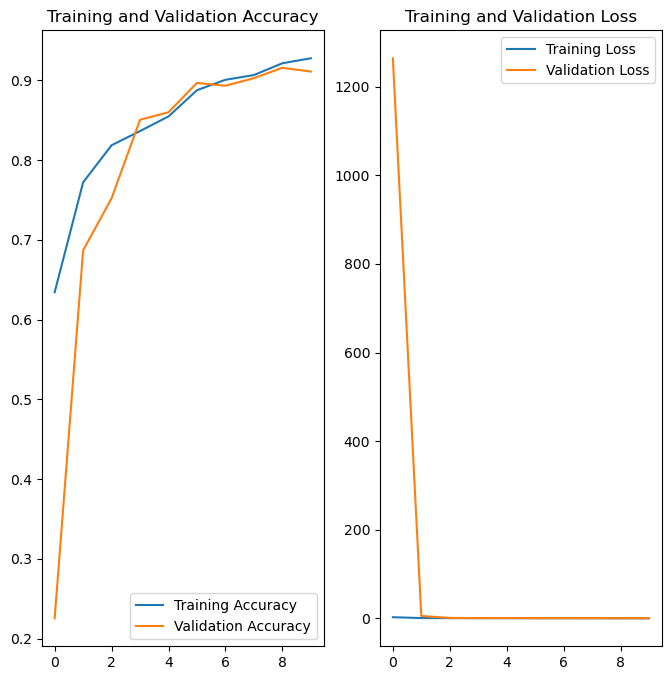

In [17]:
epochs = 10 # number of training cycles the model will go through.
eye_acc = history.history['accuracy']
eye_val_acc = history.history['val_accuracy']

eye_loss = history.history['loss']
eye_val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, eye_acc, label='Training Accuracy') 
plt.plot(epochs_range, eye_val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, eye_loss, label='Training Loss')
plt.plot(epochs_range, eye_val_loss, label='Validation Loss')
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss')
plt.show()

In [18]:
preformance = model.evaluate(eye_validation_ds)

27/27 [==============================] - 267s 10s/step - loss: 0.4099 - accuracy: 0.9110


actual label: cataract
1/1 [==============================] - 13s 13s/step
predicted label: cataract


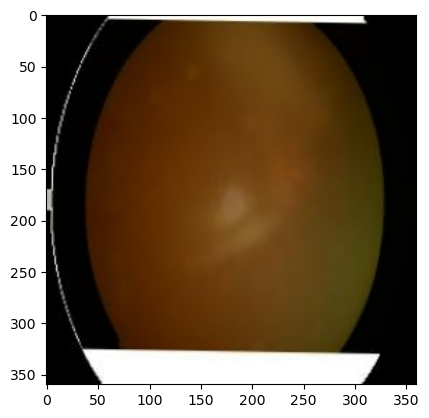

In [19]:
eye_labels = eye_train_ds.class_names 

eye_labels
for eye_images_batch, eye_labels_batch in eye_validation_ds.take(1): 
    
    eye_image = eye_images_batch[0].numpy().astype('uint8')
    eye_label = eye_labels_batch[0].numpy() 
    
    plt.imshow(eye_image) 
    print("actual label:", eye_labels[eye_label]) 
    
    batch_prediction = model.predict(eye_images_batch) 
    print("predicted label:", eye_labels[np.argmax(batch_prediction[0])]) 

In [20]:
from tensorflow import expand_dims, newaxis # imports two functions from the tensorflow module that are used to add an extra dimension to the input image.

def predict(model, eye_img): 
    
    eye_img_array = eye_img.numpy() 
    eye_img_array = expand_dims(eye_img_array, 0) 

    eye_predictions = model.predict(eye_img_array) 

    eye_predicted_class = eye_labels[np.argmax(eye_predictions[0])]
    eye_confidence = round( (np.max(eye_predictions[0])), 2) 
    return eye_predicted_class, eye_confidence 

1/1 [==============================] - 1s 536ms/step


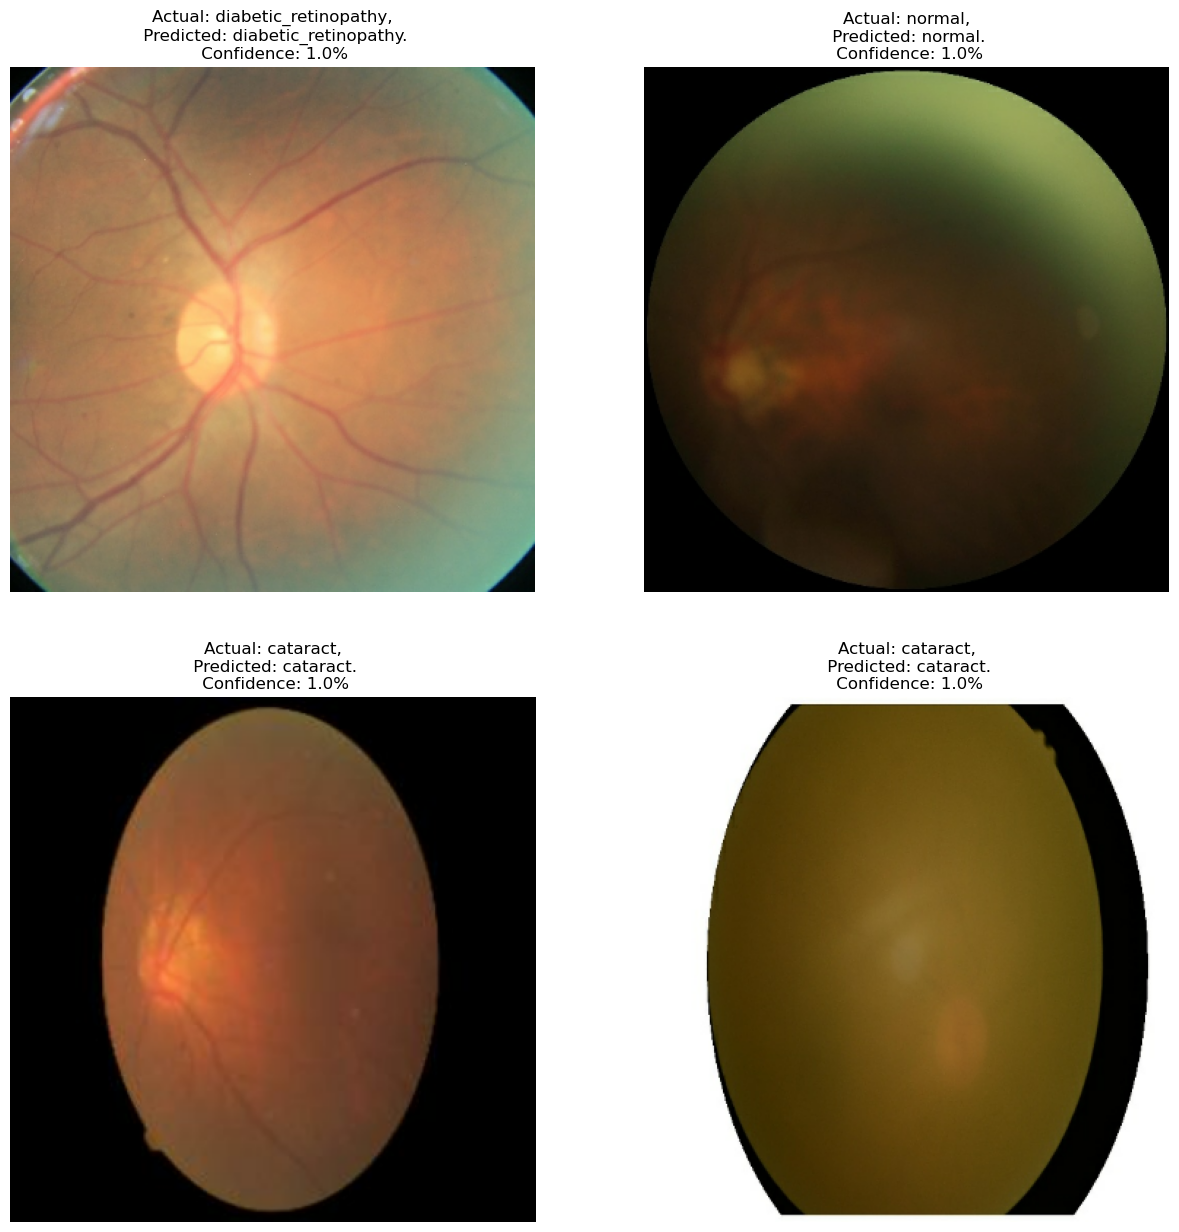

In [21]:
plt.figure(figsize=(15, 15))

for eye_images, lbs in eye_validation_ds.take(1): 
    for i in range(4): 
        
        plt.subplot(2, 2, i + 1) 
        plt.imshow(eye_images[i].numpy().astype("uint32")) 
        
        eye_predicted_class, eye_confidence = predict(model, eye_images[i]) 
        eye_actual_class = eye_labels[lbs[i]]  
        
        plt.axis("off") 